# HDB Resale Price Regression Models: KNN, PCR, and Neural Networks


**Models implemented:**
1. K-Nearest Neighbors (KNN) Regression
2. Principal Component Regression (PCR)
3. Neural Network (Multi-layer Perceptron)

**Common settings:**
- 80/20 train-test split
- 5-fold Cross-Validation (CV) for hypertuning
- RMSE used as main metric
- StandardScaler applied for KNN and NN (distance-based methods require scaling)


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Check if MPS (Apple GPU) is available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


## Load and Prepare Data


In [2]:
DATA_PATH = "../data/HDB_data_2021_sample.xlsx"

df = pd.read_excel(DATA_PATH)

# drop rows with missing resale_price
df = df.dropna(subset=["resale_price"])

# define target: use log(price) for nicer regression properties
df["log_resale_price"] = np.log(df["resale_price"])


### Feature Selection for Models


In [3]:
# for KNN, PCR, and NN, we'll use all columns except the target and year (year is constant 2021)
drop_cols_full = ["resale_price", "log_resale_price", "year"]
X_full = df.drop(columns=drop_cols_full)
y = df["log_resale_price"].values

feature_names_full = X_full.columns.tolist()
print(f"Total number of features: {len(feature_names_full)}")


Total number of features: 228


## Train-Test Split (80/20)


In [4]:
X_full_train, X_full_test, y_train, y_test = train_test_split(
    X_full, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_full_train.shape[0]}")
print(f"Test set size: {X_full_test.shape[0]}")


Training set size: 4800
Test set size: 1200


## Utility: Compute Metrics

In [5]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)


def r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

## K-Nearest Neighbors (KNN) Regression

KNN is a non-parametric method that predicts based on the average of the k nearest neighbors. It requires feature scaling since it uses distance metrics.


In [6]:
# Standardize features for KNN (distance-based method requires scaling)
scaler_knn = StandardScaler()
X_full_train_scaled_knn = scaler_knn.fit_transform(X_full_train)
X_full_test_scaled_knn = scaler_knn.transform(X_full_test)

# Baseline: KNN with default parameters (n_neighbors=5)
knn_baseline = KNeighborsRegressor()
knn_baseline.fit(X_full_train_scaled_knn, y_train)

y_pred_train_knn_base = knn_baseline.predict(X_full_train_scaled_knn)
y_pred_test_knn_base = knn_baseline.predict(X_full_test_scaled_knn)

print(f"KNN Baseline - Train RMSE: {rmse(y_train, y_pred_train_knn_base):.4f}")
print(f"KNN Baseline - Train MAE:  {mae(y_train, y_pred_train_knn_base):.4f}")
print(f"KNN Baseline - Train R²:   {r2(y_train, y_pred_train_knn_base):.4f}")
print(f"KNN Baseline - Test  RMSE: {rmse(y_test, y_pred_test_knn_base):.4f}")
print(f"KNN Baseline - Test  MAE:  {mae(y_test, y_pred_test_knn_base):.4f}")
print(f"KNN Baseline - Test  R²:   {r2(y_test, y_pred_test_knn_base):.4f}")

KNN Baseline - Train RMSE: 0.1081
KNN Baseline - Train MAE:  0.0767
KNN Baseline - Train R²:   0.8844
KNN Baseline - Test  RMSE: 0.1423
KNN Baseline - Test  MAE:  0.1026
KNN Baseline - Test  R²:   0.8063


In [7]:
# Hypertuned KNN with GridSearchCV
# Hyperparameters to tune: n_neighbors, weights, metric
knn_param_grid = {
    "n_neighbors": [3, 5, 7, 10, 15, 20, 25],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"],
}

knn_grid = GridSearchCV(
    estimator=KNeighborsRegressor(),
    param_grid=knn_param_grid,
    scoring="neg_mean_squared_error",
    cv=5,
    n_jobs=-1,
    verbose=1,
)

knn_grid.fit(X_full_train_scaled_knn, y_train)

best_knn = knn_grid.best_estimator_
y_pred_train_knn_tuned = best_knn.predict(X_full_train_scaled_knn)
y_pred_test_knn_tuned = best_knn.predict(X_full_test_scaled_knn)

print(f"\nKNN Tuned - Best Params: {knn_grid.best_params_}")
print(f"KNN Tuned - Train RMSE: {rmse(y_train, y_pred_train_knn_tuned):.4f}")
print(f"KNN Tuned - Train MAE:  {mae(y_train, y_pred_train_knn_tuned):.4f}")
print(f"KNN Tuned - Train R²:   {r2(y_train, y_pred_train_knn_tuned):.4f}")
print(f"KNN Tuned - Test  RMSE: {rmse(y_test, y_pred_test_knn_tuned):.4f}")
print(f"KNN Tuned - Test  MAE:  {mae(y_test, y_pred_test_knn_tuned):.4f}")
print(f"KNN Tuned - Test  R²:   {r2(y_test, y_pred_test_knn_tuned):.4f}")

Fitting 5 folds for each of 28 candidates, totalling 140 fits

KNN Tuned - Best Params: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
KNN Tuned - Train RMSE: 0.0041
KNN Tuned - Train MAE:  0.0005
KNN Tuned - Train R²:   0.9998
KNN Tuned - Test  RMSE: 0.1242
KNN Tuned - Test  MAE:  0.0863
KNN Tuned - Test  R²:   0.8525


### KNN Visualizations


Creating elbow plot for KNN...


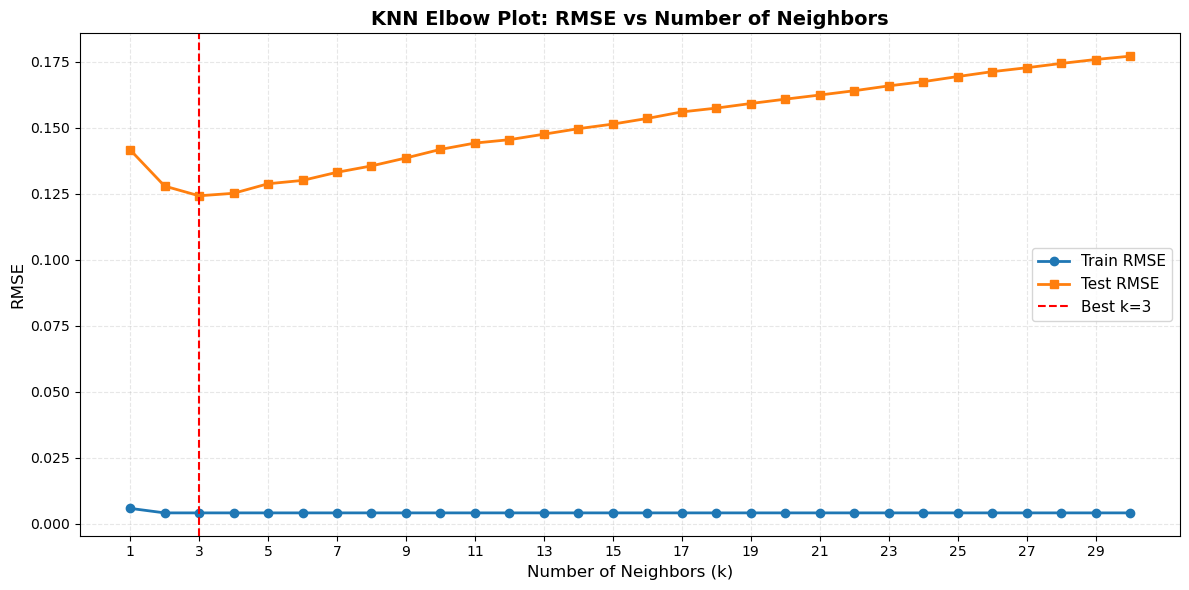

Best k from grid search: 3
Test RMSE at k=3: 0.1242


In [8]:
# 1. Elbow Plot: RMSE vs Number of Neighbors (k)
# This helps visualize the optimal k value
print("Creating elbow plot for KNN...")
k_values = range(1, 31)  # Test k from 1 to 30
train_rmse_scores = []
test_rmse_scores = []

for k in k_values:
    knn_temp = KNeighborsRegressor(n_neighbors=k, weights='distance', metric='manhattan')
    knn_temp.fit(X_full_train_scaled_knn, y_train)
    
    y_pred_train_temp = knn_temp.predict(X_full_train_scaled_knn)
    y_pred_test_temp = knn_temp.predict(X_full_test_scaled_knn)
    
    train_rmse_scores.append(rmse(y_train, y_pred_train_temp))
    test_rmse_scores.append(rmse(y_test, y_pred_test_temp))

# Create elbow plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(k_values, train_rmse_scores, 'o-', label='Train RMSE', linewidth=2, markersize=6)
ax.plot(k_values, test_rmse_scores, 's-', label='Test RMSE', linewidth=2, markersize=6)
ax.axvline(x=best_knn.n_neighbors, color='r', linestyle='--', linewidth=1.5, 
           label=f'Best k={best_knn.n_neighbors}')
ax.set_xlabel('Number of Neighbors (k)', fontsize=12)
ax.set_ylabel('RMSE', fontsize=12)
ax.set_title('KNN Elbow Plot: RMSE vs Number of Neighbors', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3, linestyle='--')
ax.set_xticks(range(1, 31, 2))
plt.tight_layout()
plt.show()

print(f"Best k from grid search: {best_knn.n_neighbors}")
print(f"Test RMSE at k={best_knn.n_neighbors}: {test_rmse_scores[best_knn.n_neighbors-1]:.4f}")


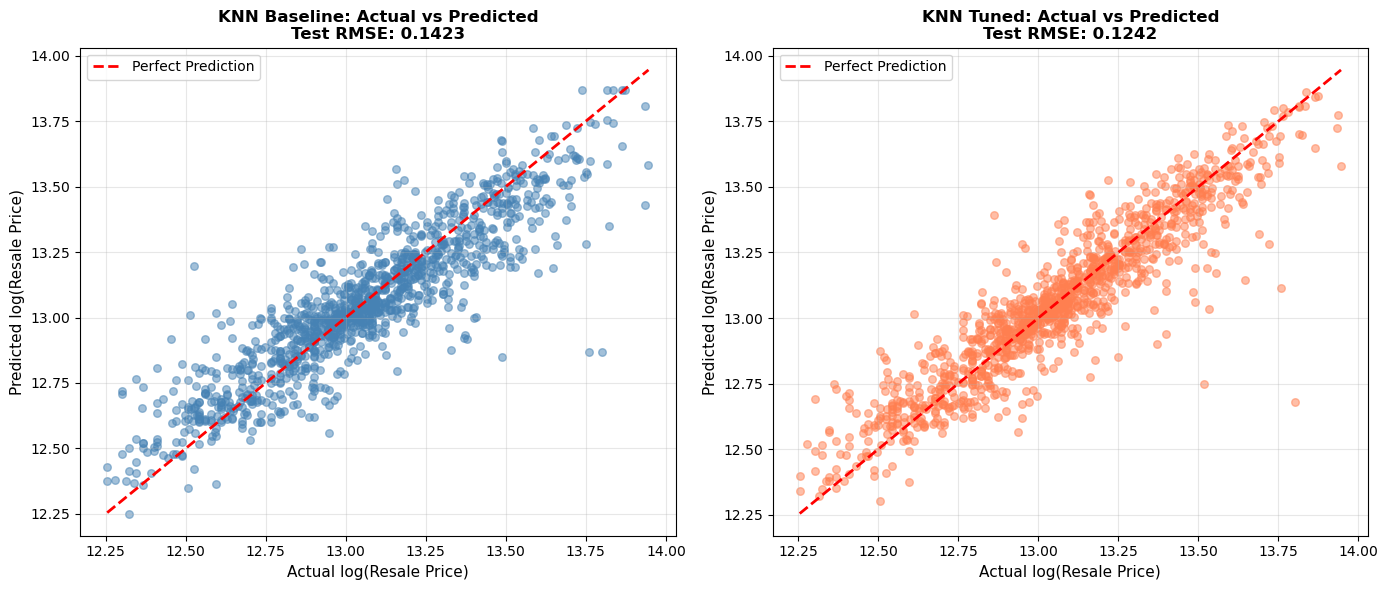

In [9]:
# 2. Actual vs Predicted Scatter Plot (Test Set)
# Shows how well predictions match actual values
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Baseline model
axes[0].scatter(y_test, y_pred_test_knn_base, alpha=0.5, s=30, color='steelblue')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual log(Resale Price)', fontsize=11)
axes[0].set_ylabel('Predicted log(Resale Price)', fontsize=11)
axes[0].set_title(f'KNN Baseline: Actual vs Predicted\nTest RMSE: {rmse(y_test, y_pred_test_knn_base):.4f}', 
                  fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Tuned model
axes[1].scatter(y_test, y_pred_test_knn_tuned, alpha=0.5, s=30, color='coral')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual log(Resale Price)', fontsize=11)
axes[1].set_ylabel('Predicted log(Resale Price)', fontsize=11)
axes[1].set_title(f'KNN Tuned: Actual vs Predicted\nTest RMSE: {rmse(y_test, y_pred_test_knn_tuned):.4f}', 
                  fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


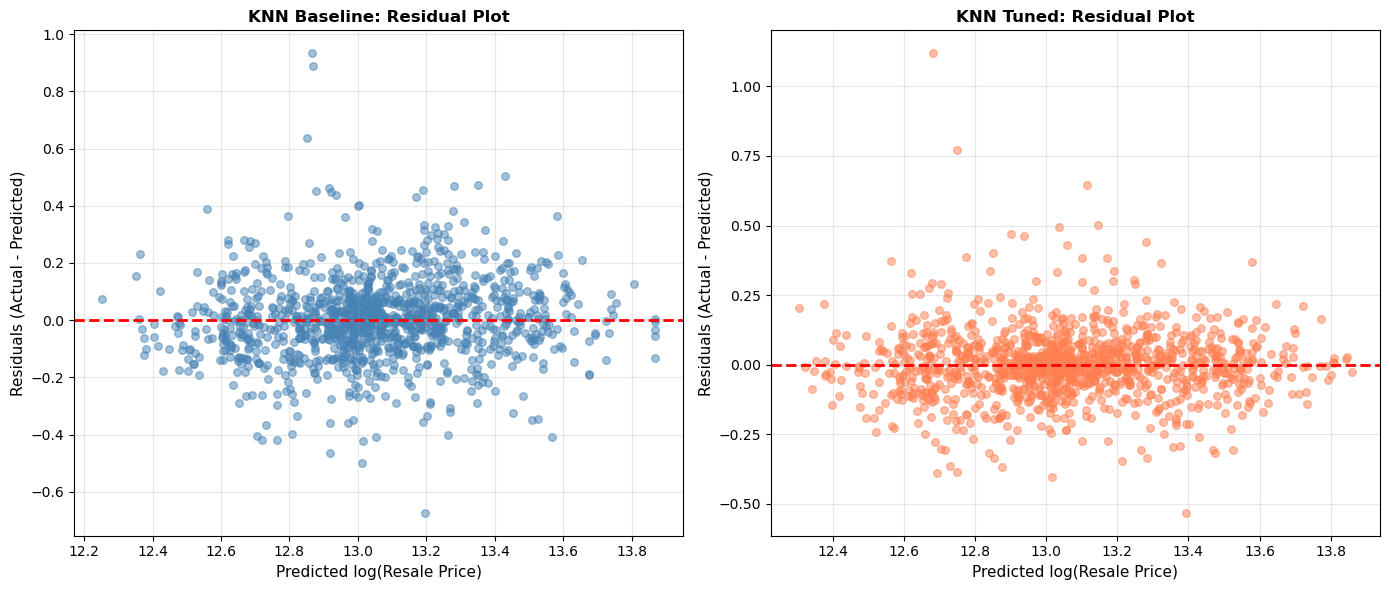

Residual Statistics (Test Set):
Baseline - Mean: 0.003313, Std: 0.1423
Tuned    - Mean: 0.000374, Std: 0.1242

Ideal residuals should be centered around 0 with constant variance.


In [10]:
# 3. Residual Plot (Test Set)
# Shows prediction errors - helps identify patterns in residuals
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Baseline residuals
residuals_baseline = y_test - y_pred_test_knn_base
axes[0].scatter(y_pred_test_knn_base, residuals_baseline, alpha=0.5, s=30, color='steelblue')
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted log(Resale Price)', fontsize=11)
axes[0].set_ylabel('Residuals (Actual - Predicted)', fontsize=11)
axes[0].set_title('KNN Baseline: Residual Plot', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

# Tuned residuals
residuals_tuned = y_test - y_pred_test_knn_tuned
axes[1].scatter(y_pred_test_knn_tuned, residuals_tuned, alpha=0.5, s=30, color='coral')
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted log(Resale Price)', fontsize=11)
axes[1].set_ylabel('Residuals (Actual - Predicted)', fontsize=11)
axes[1].set_title('KNN Tuned: Residual Plot', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print residual statistics
print("Residual Statistics (Test Set):")
print(f"Baseline - Mean: {np.mean(residuals_baseline):.6f}, Std: {np.std(residuals_baseline):.4f}")
print(f"Tuned    - Mean: {np.mean(residuals_tuned):.6f}, Std: {np.std(residuals_tuned):.4f}")
print(f"\nIdeal residuals should be centered around 0 with constant variance.")


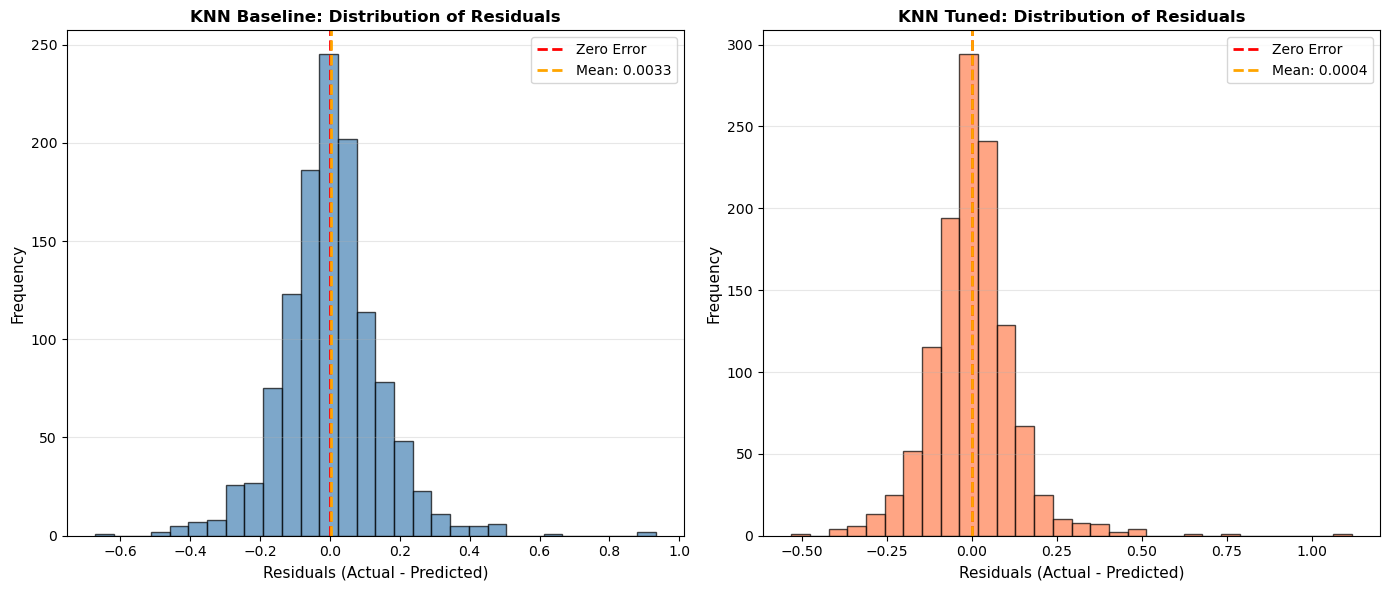

In [11]:
# 4. Distribution of Prediction Errors
# Shows the distribution of residuals to check for normality
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Baseline error distribution
axes[0].hist(residuals_baseline, bins=30, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
axes[0].axvline(x=np.mean(residuals_baseline), color='orange', linestyle='--', linewidth=2, 
                label=f'Mean: {np.mean(residuals_baseline):.4f}')
axes[0].set_xlabel('Residuals (Actual - Predicted)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('KNN Baseline: Distribution of Residuals', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3, axis='y')

# Tuned error distribution
axes[1].hist(residuals_tuned, bins=30, alpha=0.7, color='coral', edgecolor='black')
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
axes[1].axvline(x=np.mean(residuals_tuned), color='orange', linestyle='--', linewidth=2, 
                label=f'Mean: {np.mean(residuals_tuned):.4f}')
axes[1].set_xlabel('Residuals (Actual - Predicted)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('KNN Tuned: Distribution of Residuals', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


## Principal Component Regression (PCR)

PCR combines Principal Component Analysis (PCA) with linear regression. It reduces dimensionality by projecting features onto principal components, which can help with multicollinearity and overfitting.


In [12]:
# Standardize features for PCR (PCA is sensitive to scale)
scaler_pcr = StandardScaler()
X_full_train_scaled_pcr = scaler_pcr.fit_transform(X_full_train)
X_full_test_scaled_pcr = scaler_pcr.transform(X_full_test)

# Baseline: PCR with a fixed number of components (e.g., 10)
# We'll use 10 components as a reasonable baseline
n_components_baseline = 10
pca_baseline = PCA(n_components=n_components_baseline)
X_pca_train_base = pca_baseline.fit_transform(X_full_train_scaled_pcr)
X_pca_test_base = pca_baseline.transform(X_full_test_scaled_pcr)

pcr_baseline = LinearRegression()
pcr_baseline.fit(X_pca_train_base, y_train)

y_pred_train_pcr_base = pcr_baseline.predict(X_pca_train_base)
y_pred_test_pcr_base = pcr_baseline.predict(X_pca_test_base)

print(
    f"PCR Baseline (n_components={n_components_baseline}) - Train RMSE: {rmse(y_train, y_pred_train_pcr_base):.4f}"
)
print(
    f"PCR Baseline (n_components={n_components_baseline}) - Train MAE:  {mae(y_train, y_pred_train_pcr_base):.4f}"
)
print(
    f"PCR Baseline (n_components={n_components_baseline}) - Train R²:   {r2(y_train, y_pred_train_pcr_base):.4f}"
)
print(
    f"PCR Baseline (n_components={n_components_baseline}) - Test  RMSE: {rmse(y_test, y_pred_test_pcr_base):.4f}"
)
print(
    f"PCR Baseline (n_components={n_components_baseline}) - Test  MAE:  {mae(y_test, y_pred_test_pcr_base):.4f}"
)
print(
    f"PCR Baseline (n_components={n_components_baseline}) - Test  R²:   {r2(y_test, y_pred_test_pcr_base):.4f}"
)

# Check explained variance
explained_var = np.sum(pca_baseline.explained_variance_ratio_)
print(
    f"\nExplained variance ratio (first {n_components_baseline} components): {explained_var:.4f}"
)

PCR Baseline (n_components=10) - Train RMSE: 0.2419
PCR Baseline (n_components=10) - Train MAE:  0.1918
PCR Baseline (n_components=10) - Train R²:   0.4213
PCR Baseline (n_components=10) - Test  RMSE: 0.2434
PCR Baseline (n_components=10) - Test  MAE:  0.1914
PCR Baseline (n_components=10) - Test  R²:   0.4333

Explained variance ratio (first 10 components): 0.2991


Cumulative explained variance by number of components:
   5 components: 0.1931
  10 components: 0.2991
  15 components: 0.3811
  20 components: 0.4496
  25 components: 0.5106
  30 components: 0.5644
  50 components: 0.7123


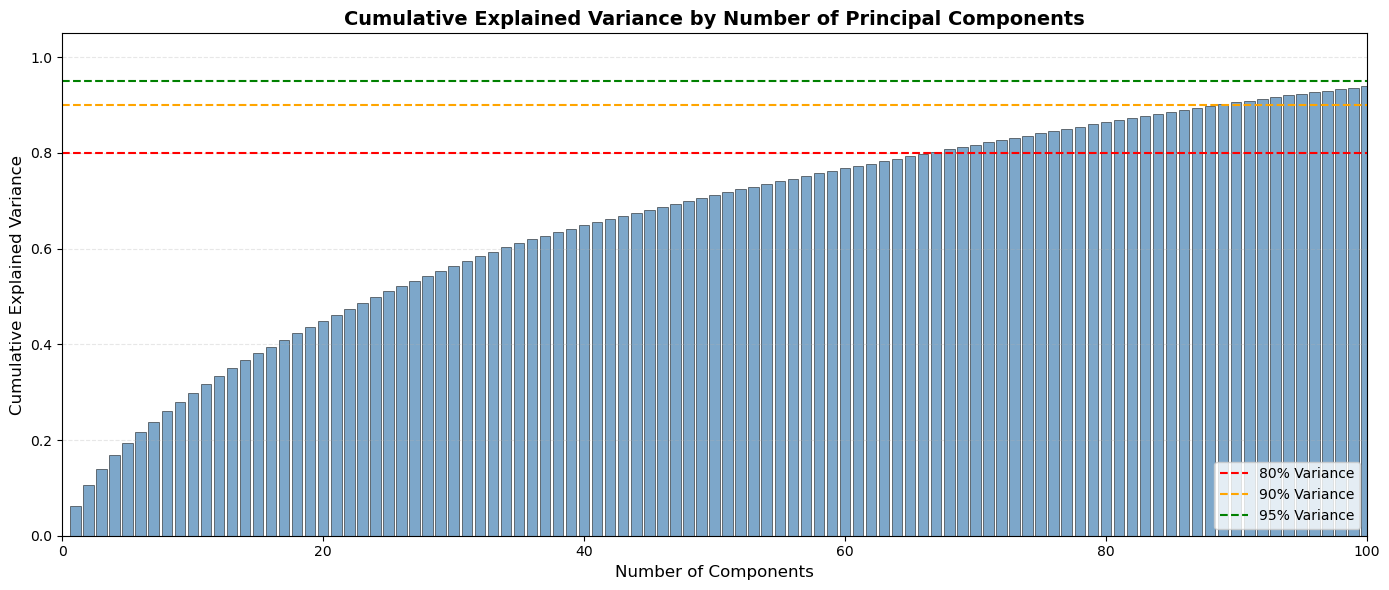


Summary:
  Total number of components: 228
  Components needed for 80% variance: 67
  Components needed for 90% variance: 89
  Components needed for 95% variance: 105


In [13]:
# First, let's check how many components explain different amounts of variance
pca_full = PCA()
pca_full.fit(X_full_train_scaled_pcr)

cumulative_var = np.cumsum(pca_full.explained_variance_ratio_)
n_components = len(cumulative_var)

print("Cumulative explained variance by number of components:")
for n in [5, 10, 15, 20, 25, 30, min(50, n_components)]:
    if n <= n_components:
        print(f"  {n:2d} components: {cumulative_var[n-1]:.4f}")

# Create bar chart showing cumulative explained variance for all components
plt.figure(figsize=(14, 6))
component_numbers = np.arange(1, n_components + 1)
plt.bar(component_numbers, cumulative_var, alpha=0.7, color='steelblue', edgecolor='black', linewidth=0.5)
plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance', fontsize=12)
plt.title('Cumulative Explained Variance by Number of Principal Components', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.axhline(y=0.8, color='r', linestyle='--', linewidth=1.5, label='80% Variance')
plt.axhline(y=0.9, color='orange', linestyle='--', linewidth=1.5, label='90% Variance')
plt.axhline(y=0.95, color='green', linestyle='--', linewidth=1.5, label='95% Variance')
plt.legend(loc='lower right')
plt.xlim(0, min(n_components + 5, 100))  # Show up to 100 components or all if less
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nSummary:")
print(f"  Total number of components: {n_components}")
print(f"  Components needed for 80% variance: {np.argmax(cumulative_var >= 0.8) + 1}")
print(f"  Components needed for 90% variance: {np.argmax(cumulative_var >= 0.9) + 1}")
print(f"  Components needed for 95% variance: {np.argmax(cumulative_var >= 0.95) + 1}")


In [14]:
# Hypertuned PCR: tune number of components using GridSearchCV
# We'll search over a range of component numbers
max_components = min(
    50, X_full_train_scaled_pcr.shape[1], X_full_train_scaled_pcr.shape[0] - 1
)
component_range = list(range(5, max_components + 1, 5))  # Try 5, 10, 15, ..., up to max

# Create a pipeline for PCR
pcr_pipeline = Pipeline(
    [("scaler", StandardScaler()), ("pca", PCA()), ("regression", LinearRegression())]
)

pcr_param_grid = {"pca__n_components": component_range}

pcr_grid = GridSearchCV(
    estimator=pcr_pipeline,
    param_grid=pcr_param_grid,
    scoring="neg_mean_squared_error",
    cv=5,
    n_jobs=-1,
    verbose=1,
)

pcr_grid.fit(X_full_train, y_train)

best_pcr = pcr_grid.best_estimator_
y_pred_train_pcr_tuned = best_pcr.predict(X_full_train)
y_pred_test_pcr_tuned = best_pcr.predict(X_full_test)

print(f"\nPCR Tuned - Best n_components: {pcr_grid.best_params_['pca__n_components']}")
print(f"PCR Tuned - Train RMSE: {rmse(y_train, y_pred_train_pcr_tuned):.4f}")
print(f"PCR Tuned - Train MAE:  {mae(y_train, y_pred_train_pcr_tuned):.4f}")
print(f"PCR Tuned - Train R²:   {r2(y_train, y_pred_train_pcr_tuned):.4f}")
print(f"PCR Tuned - Test  RMSE: {rmse(y_test, y_pred_test_pcr_tuned):.4f}")
print(f"PCR Tuned - Test  MAE:  {mae(y_test, y_pred_test_pcr_tuned):.4f}")
print(f"PCR Tuned - Test  R²:   {r2(y_test, y_pred_test_pcr_tuned):.4f}")

# Get explained variance for best model
best_n_components = pcr_grid.best_params_["pca__n_components"]
pca_best = best_pcr.named_steps["pca"]
explained_var_best = np.sum(pca_best.explained_variance_ratio_)
print(
    f"\nExplained variance ratio (best {best_n_components} components): {explained_var_best:.4f}"
)

Fitting 5 folds for each of 10 candidates, totalling 50 fits

PCR Tuned - Best n_components: 50
PCR Tuned - Train RMSE: 0.1323
PCR Tuned - Train MAE:  0.1012
PCR Tuned - Train R²:   0.8270
PCR Tuned - Test  RMSE: 0.1322
PCR Tuned - Test  MAE:  0.1022
PCR Tuned - Test  R²:   0.8329

Explained variance ratio (best 50 components): 0.7123


## Neural Network (Multi-layer Perceptron)

Neural networks can capture complex non-linear relationships. We'll use sklearn's MLPRegressor, which is a feedforward neural network.


In [15]:
# Define PyTorch neural network model and training functions
class MLPRegressor(nn.Module):
    def __init__(self, input_size, hidden_sizes=(100,), activation='relu', alpha=0.0001):
        super(MLPRegressor, self).__init__()
        
        # Build layers
        layers = []
        prev_size = input_size
        
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'leaky_relu':
                layers.append(nn.LeakyReLU(negative_slope=0.01))
            elif activation == 'tanh':
                layers.append(nn.Tanh())
            prev_size = hidden_size
        
        # Output layer (single value for regression)
        layers.append(nn.Linear(prev_size, 1))
        
        self.network = nn.Sequential(*layers)
        self.alpha = alpha  # L2 regularization (weight decay)
        
    def forward(self, x):
        return self.network(x).squeeze()

# Training function
def train_pytorch_nn(X_train, y_train, X_val, y_val, hidden_sizes=(100,), 
                     activation='relu', alpha=0.001, learning_rate=0.001,
                     epochs=300, batch_size=64, patience=30, device=device):
    """
    Train a PyTorch neural network with early stopping.
    Returns: trained model, training history
    """
    # Convert to tensors
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.FloatTensor(y_train).to(device)
    X_val_tensor = torch.FloatTensor(X_val).to(device)
    y_val_tensor = torch.FloatTensor(y_val).to(device)
    
    # Create model
    model = MLPRegressor(
        input_size=X_train.shape[1],
        hidden_sizes=hidden_sizes,
        activation=activation,
        alpha=alpha
    ).to(device)
    
    # Loss and optimizer (Adam with weight decay for L2 regularization)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=alpha)
    
    # Training with early stopping
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), 
                             batch_size=batch_size, shuffle=True)
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        # Validation
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val_tensor)
            val_loss = criterion(y_val_pred, y_val_tensor).item()
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, {'train_losses': train_losses, 'val_losses': val_losses}

# Prediction function
def predict_pytorch_nn(model, X, device=device):
    """Make predictions with PyTorch model"""
    model.eval()
    X_tensor = torch.FloatTensor(X).to(device)
    with torch.no_grad():
        y_pred = model(X_tensor).cpu().numpy()
    return y_pred


In [16]:
# Standardize features for Neural Network (required for convergence)
scaler_nn = StandardScaler()
X_full_train_scaled_nn = scaler_nn.fit_transform(X_full_train)
X_full_test_scaled_nn = scaler_nn.transform(X_full_test)

# Baseline: Simple MLP with default parameters
print("Training baseline neural network...")
print("Parameters: hidden_sizes=(100,), activation='relu', lr=0.001")

# Split training data for validation (10% for early stopping)
X_nn_train, X_nn_val, y_nn_train, y_nn_val = train_test_split(
    X_full_train_scaled_nn, y_train, test_size=0.1, random_state=42
)

nn_baseline, baseline_history = train_pytorch_nn(
    X_nn_train,
    y_nn_train,
    X_nn_val,
    y_nn_val,
    hidden_sizes=(100,),
    activation="relu",
    learning_rate=0.001,
    epochs=300,
    device=device,
)

y_pred_train_nn_base = predict_pytorch_nn(nn_baseline, X_full_train_scaled_nn, device)
y_pred_test_nn_base = predict_pytorch_nn(nn_baseline, X_full_test_scaled_nn, device)

print(f"\nNN Baseline - Train RMSE: {rmse(y_train, y_pred_train_nn_base):.4f}")
print(f"NN Baseline - Train MAE:  {mae(y_train, y_pred_train_nn_base):.4f}")
print(f"NN Baseline - Train R²:   {r2(y_train, y_pred_train_nn_base):.4f}")
print(f"NN Baseline - Test  RMSE: {rmse(y_test, y_pred_test_nn_base):.4f}")
print(f"NN Baseline - Test  MAE:  {mae(y_test, y_pred_test_nn_base):.4f}")
print(f"NN Baseline - Test  R²:   {r2(y_test, y_pred_test_nn_base):.4f}")
print(f"NN Baseline - Training epochs: {len(baseline_history['train_losses'])}")

Training baseline neural network...
Parameters: hidden_sizes=(100,), activation='relu', lr=0.001

NN Baseline - Train RMSE: 0.2003
NN Baseline - Train MAE:  0.1040
NN Baseline - Train R²:   0.6033
NN Baseline - Test  RMSE: 0.1995
NN Baseline - Test  MAE:  0.1265
NN Baseline - Test  R²:   0.6192
NN Baseline - Training epochs: 163


In [17]:
print("Starting hyperparameter tuning with 5-fold CV...")
kf = KFold(n_splits=5, shuffle=True, random_state=42)

param_combinations = []
for hidden_sizes in [(50,), (100,), (150,), (100, 50)]:
    for activation in ["relu", "leaky_relu", "tanh"]:
        for lr in [0.001, 0.01, 0.1]:
            param_combinations.append(
                {
                    "hidden_sizes": hidden_sizes,
                    "activation": activation,
                    "learning_rate": lr,
                }
            )

print(f"Testing {len(param_combinations)} parameter combinations\n")

best_score = float("inf")
best_params = None

# Grid search with cross-validation
for i, params in enumerate(param_combinations):
    print(f"Testing {i+1}/{len(param_combinations)}: {params}")

    cv_rmse_scores = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_full_train_scaled_nn)):
        X_tr, X_val = X_full_train_scaled_nn[train_idx], X_full_train_scaled_nn[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        # Use the CV validation fold for early stopping
        model, _ = train_pytorch_nn(
            X_tr,
            y_tr,
            X_val,
            y_val,
            hidden_sizes=params["hidden_sizes"],
            activation=params["activation"],
            learning_rate=params["learning_rate"],
            epochs=500,
            device=device,
        )

        # Evaluate on the CV validation fold
        y_val_pred = predict_pytorch_nn(model, X_val, device)
        cv_rmse_scores.append(rmse(y_val, y_val_pred))

    mean_cv_rmse = np.mean(cv_rmse_scores)
    print(f"  Mean CV RMSE: {mean_cv_rmse:.4f}\n")

    if mean_cv_rmse < best_score:
        best_score = mean_cv_rmse
        best_params = params.copy()

print("=" * 60)
print("HYPERPARAMETER TUNING COMPLETE")
print("=" * 60)
print(f"Best parameters: {best_params}")
print(f"Best CV RMSE: {best_score:.4f}")

# Retrain on FULL training set with best hyperparameters
# Split training data for validation (10% for early stopping)
X_tr_inner, X_val_inner, y_tr_inner, y_val_inner = train_test_split(
    X_full_train_scaled_nn, y_train, test_size=0.1, random_state=42
)

final_model, _ = train_pytorch_nn(
    X_tr_inner,
    y_tr_inner,
    X_val_inner,
    y_val_inner,
    hidden_sizes=best_params["hidden_sizes"],
    activation=best_params["activation"],
    learning_rate=best_params["learning_rate"],
    epochs=500,
    device=device,
)

# Evaluate final model
y_pred_test_nn_tuned = predict_pytorch_nn(final_model, X_full_test_scaled_nn, device)
y_pred_train_nn_tuned = predict_pytorch_nn(final_model, X_full_train_scaled_nn, device)

print(f"\nNN Tuned - Train RMSE: {rmse(y_train, y_pred_train_nn_tuned):.4f}")
print(f"NN Tuned - Train MAE:  {mae(y_train, y_pred_train_nn_tuned):.4f}")
print(f"NN Tuned - Train R²:   {r2(y_train, y_pred_train_nn_tuned):.4f}")
print(f"NN Tuned - Test  RMSE: {rmse(y_test, y_pred_test_nn_tuned):.4f}")
print(f"NN Tuned - Test  MAE:  {mae(y_test, y_pred_test_nn_tuned):.4f}")
print(f"NN Tuned - Test  R²:   {r2(y_test, y_pred_test_nn_tuned):.4f}")

Starting hyperparameter tuning with 5-fold CV...
Testing 36 parameter combinations

Testing 1/36: {'hidden_sizes': (50,), 'activation': 'relu', 'learning_rate': 0.001}
  Mean CV RMSE: 0.2182

Testing 2/36: {'hidden_sizes': (50,), 'activation': 'relu', 'learning_rate': 0.01}
  Mean CV RMSE: 0.3121

Testing 3/36: {'hidden_sizes': (50,), 'activation': 'relu', 'learning_rate': 0.1}
  Mean CV RMSE: 32.2935

Testing 4/36: {'hidden_sizes': (50,), 'activation': 'leaky_relu', 'learning_rate': 0.001}
  Mean CV RMSE: 0.2137

Testing 5/36: {'hidden_sizes': (50,), 'activation': 'leaky_relu', 'learning_rate': 0.01}
  Mean CV RMSE: 0.3569

Testing 6/36: {'hidden_sizes': (50,), 'activation': 'leaky_relu', 'learning_rate': 0.1}
  Mean CV RMSE: 15.1914

Testing 7/36: {'hidden_sizes': (50,), 'activation': 'tanh', 'learning_rate': 0.001}
  Mean CV RMSE: 0.3875

Testing 8/36: {'hidden_sizes': (50,), 'activation': 'tanh', 'learning_rate': 0.01}
  Mean CV RMSE: 0.3858

Testing 9/36: {'hidden_sizes': (50,), '

## Model Comparison Summary


In [18]:
# Create a summary comparison table
results_summary = pd.DataFrame(
    {
        "Model": [
            "KNN Baseline",
            "KNN Tuned",
            "PCR Baseline",
            "PCR Tuned",
            "NN Baseline",
            "NN Tuned",
        ],
        "Train RMSE": [
            rmse(y_train, y_pred_train_knn_base),
            rmse(y_train, y_pred_train_knn_tuned),
            rmse(y_train, y_pred_train_pcr_base),
            rmse(y_train, y_pred_train_pcr_tuned),
            rmse(y_train, y_pred_train_nn_base),
            rmse(y_train, y_pred_train_nn_tuned),
        ],
        "Train MAE": [
            mae(y_train, y_pred_train_knn_base),
            mae(y_train, y_pred_train_knn_tuned),
            mae(y_train, y_pred_train_pcr_base),
            mae(y_train, y_pred_train_pcr_tuned),
            mae(y_train, y_pred_train_nn_base),
            mae(y_train, y_pred_train_nn_tuned),
        ],
        "Train R²": [
            r2(y_train, y_pred_train_knn_base),
            r2(y_train, y_pred_train_knn_tuned),
            r2(y_train, y_pred_train_pcr_base),
            r2(y_train, y_pred_train_pcr_tuned),
            r2(y_train, y_pred_train_nn_base),
            r2(y_train, y_pred_train_nn_tuned),
        ],
        "Test RMSE": [
            rmse(y_test, y_pred_test_knn_base),
            rmse(y_test, y_pred_test_knn_tuned),
            rmse(y_test, y_pred_test_pcr_base),
            rmse(y_test, y_pred_test_pcr_tuned),
            rmse(y_test, y_pred_test_nn_base),
            rmse(y_test, y_pred_test_nn_tuned),
        ],
        "Test MAE": [
            mae(y_test, y_pred_test_knn_base),
            mae(y_test, y_pred_test_knn_tuned),
            mae(y_test, y_pred_test_pcr_base),
            mae(y_test, y_pred_test_pcr_tuned),
            mae(y_test, y_pred_test_nn_base),
            mae(y_test, y_pred_test_nn_tuned),
        ],
        "Test R²": [
            r2(y_test, y_pred_test_knn_base),
            r2(y_test, y_pred_test_knn_tuned),
            r2(y_test, y_pred_test_pcr_base),
            r2(y_test, y_pred_test_pcr_tuned),
            r2(y_test, y_pred_test_nn_base),
            r2(y_test, y_pred_test_nn_tuned),
        ],
    }
)

print("\n" + "=" * 60)
print("MODEL COMPARISON SUMMARY")
print("=" * 60)
print(results_summary.to_string(index=False))
print("=" * 60)

# Find best models by different metrics
best_test_rmse_idx = results_summary["Test RMSE"].idxmin()
best_test_mae_idx = results_summary["Test MAE"].idxmin()
best_test_r2_idx = results_summary["Test R²"].idxmax()

print(
    f"\nBest model (by Test RMSE): {results_summary.loc[best_test_rmse_idx, 'Model']}"
)
print(f"  Test RMSE: {results_summary.loc[best_test_rmse_idx, 'Test RMSE']:.4f}")
print(f"\nBest model (by Test MAE): {results_summary.loc[best_test_mae_idx, 'Model']}")
print(f"  Test MAE: {results_summary.loc[best_test_mae_idx, 'Test MAE']:.4f}")
print(f"\nBest model (by Test R²): {results_summary.loc[best_test_r2_idx, 'Model']}")
print(f"  Test R²: {results_summary.loc[best_test_r2_idx, 'Test R²']:.4f}")


MODEL COMPARISON SUMMARY
       Model  Train RMSE  Train MAE  Train R²  Test RMSE  Test MAE  Test R²
KNN Baseline    0.108149   0.076741  0.884355   0.142297  0.102601 0.806304
   KNN Tuned    0.004133   0.000465  0.999831   0.124174  0.086287 0.852502
PCR Baseline    0.241927   0.191806  0.421302   0.243392  0.191361 0.433319
   PCR Tuned    0.132263   0.101176  0.827035   0.132157  0.102221 0.832926
 NN Baseline    0.200316   0.104023  0.603254   0.199527  0.126529 0.619171
    NN Tuned    0.142141   0.104769  0.800233   0.136349  0.103021 0.822159

Best model (by Test RMSE): KNN Tuned
  Test RMSE: 0.1242

Best model (by Test MAE): KNN Tuned
  Test MAE: 0.0863

Best model (by Test R²): KNN Tuned
  Test R²: 0.8525
